<a href="https://colab.research.google.com/github/pedromiola28/Time-Series---System-Identification/blob/main/Time_Series_System_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sysidentpy
!pip install matplotlib==3.1.3
!pip install mat73
!pip install statsmodels
!pip install pingouin

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
import scipy
import scipy.io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pingouin 
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

from torch import nn
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation
from sysidentpy.utils.narmax_tools import regressor_code
from sysidentpy.model_structure_selection import FROLS

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import seaborn as sns

import mat73

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Mounted at /content/drive


The data was generated using Simulink, with a simple mass-springer-damper system.

The ideia is to predict the position of the system just looking at the force that is applied to it.

We will use a NARX neural network and a LSTM neural network.

#Opening matlab data

In [5]:
path = r'/content/drive/My Drive/sysident/'

x = mat73.loadmat(path +'x.mat')
exc = mat73.loadmat(path +'excitation.mat')
a = mat73.loadmat(path +'a.mat')
v = mat73.loadmat(path +'v.mat')

a = a['ans'][1] #acceleration
v = v['ans'][1] #velocity
ex = exc['ans'][1] #force (excitation)
x = x['ans'][1] #position

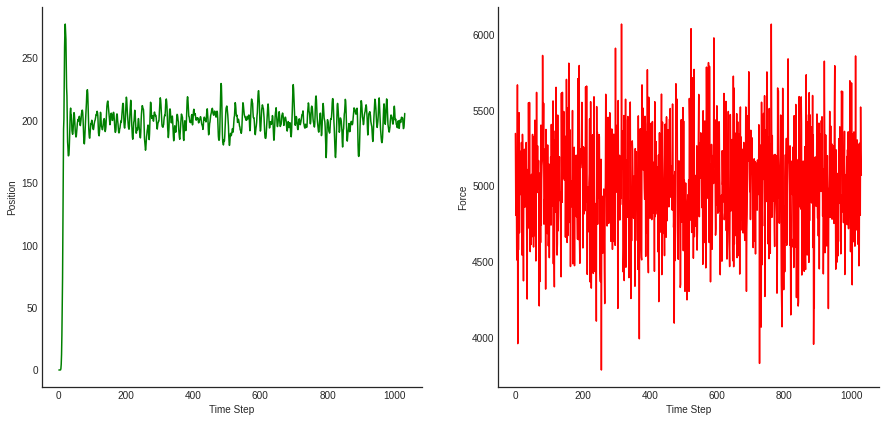

In [220]:
#Plotting data

plt.figure(figsize = [15, 7])
 
plt.subplot(121)
plt.plot(x, color="green")
plt.xlabel('Time Step')
plt.ylabel('Position')

plt.subplot(122)
plt.plot(ex, color="red")
plt.xlabel('Time Step')
plt.ylabel('Force')

plt.show()

In [13]:
X,y = ex, x #We are going to predict the position of the system based on the force that is applied

X,y = np.reshape(X, (len(X), -1)), np.reshape(y, (len(y), -1)) #Reshaping the data is needed to fit the Narx model

f = int(0.7*len(X))

x_train, y_train, x_valid, y_valid = X[:f], y[:f], X[f:], y[f:] #Spliting into training and validation datasets

scaler = MinMaxScaler() #Scaling data between 0 and 1
yscaler = scaler.fit(y_train)

y_train, y_valid = yscaler.transform(y_train), yscaler.transform(y_valid)

xscaler = scaler.fit(x_train)

x_train, x_valid = xscaler.transform(x_train), xscaler.transform(x_valid)

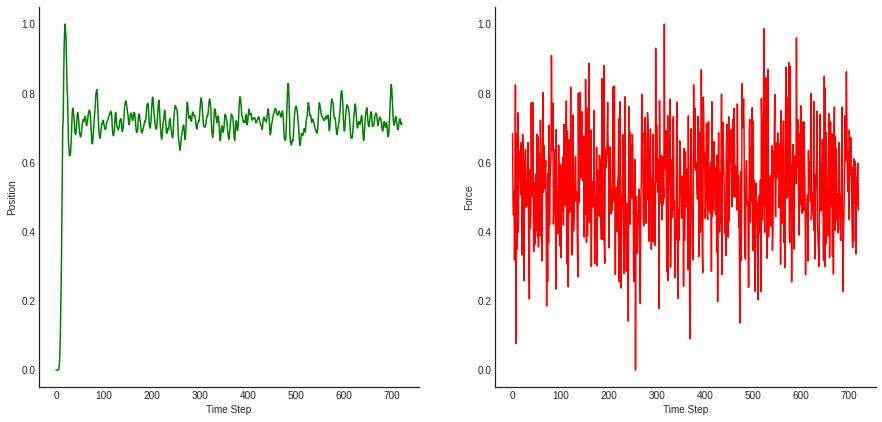

In [219]:
#Plotting scaled data
plt.figure(figsize = [15, 7])
 
plt.subplot(121)
plt.plot(y_train, color="green")
plt.xlabel('Time Step')
plt.ylabel('Position')

plt.subplot(122)
plt.plot(x_train, color="red")
plt.xlabel('Time Step')
plt.ylabel('Force')

plt.show()

Now, we should analyze our time series data. Because we are using a NARX Neural Network (Nonlinear Autoregressive with Exogenous model), we must define the lags that are going to be model features. For the ylags, we can analyze autocorrelation(AC) and partial autocorrelation(PAC). For the xlags, we can analyze the cross correlation between the position and the force time series.

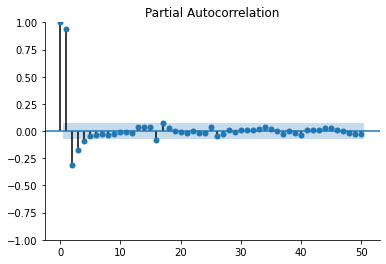

In [20]:
plot_pacf(y_train, lags = 50, method = 'ywm')
plt.show()

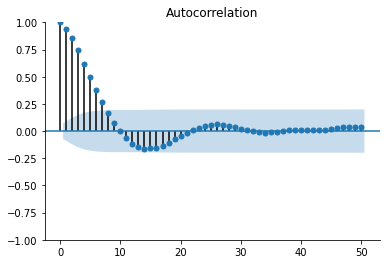

In [22]:
plot_acf(y_train, lags = 50)
plt.show()

It is possible to see that the PAC is relevant until lag 4, while the AC is relevant until lag 7. Because the PAC analyzis contains less data and is more adequate as autoregressive feature (see https://online.stat.psu.edu/stat462/node/188/), we will use ylag=4.

Its important to analyze linear and non linear correlation between the series to define our xlags. Here is an example of how different those two values can be:

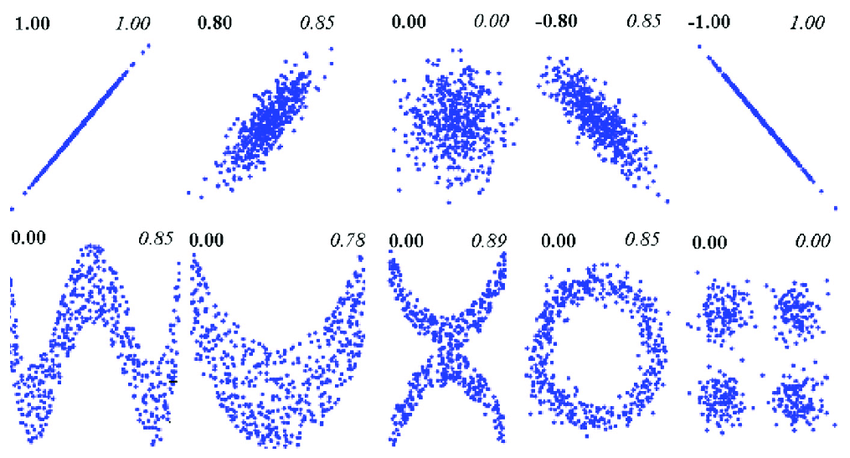

Image from: https://www.researchgate.net/figure/The-comparison-between-linear-correlation-coefficient-LCC-and-nonlinear-correlation_fig1_322349267/actions#reference

In [23]:
#Compute cross linear correlation between lagged X (inputs) and y (outputs)

def correl_lag_lin(x, y, lag):
  c = np.corrcoef(x, y)[0][1]
  correl = [c]
  y = list(y)
  x = list(x)
  for i in range(0,lag):
    x.pop(0)
    l = len(y)
    y.pop(l-1)
    c = np.corrcoef(x, y)[0][1]
    correl.append(c)
  return correl

#Compute cross non linear correlation between lagged X (inputs) and y (outputs)

def correl_lag(x, y, lag):
  c = pingouin.distance_corr(x, y, n_boot = None)
  correl = [c]
  y = list(y)
  x = list(x)
  for i in range(0,lag):
    x.pop(0)
    l = len(y)
    y.pop(l-1)
    c = pingouin.distance_corr(x, y, n_boot = None)
    correl.append(c)
  return correl

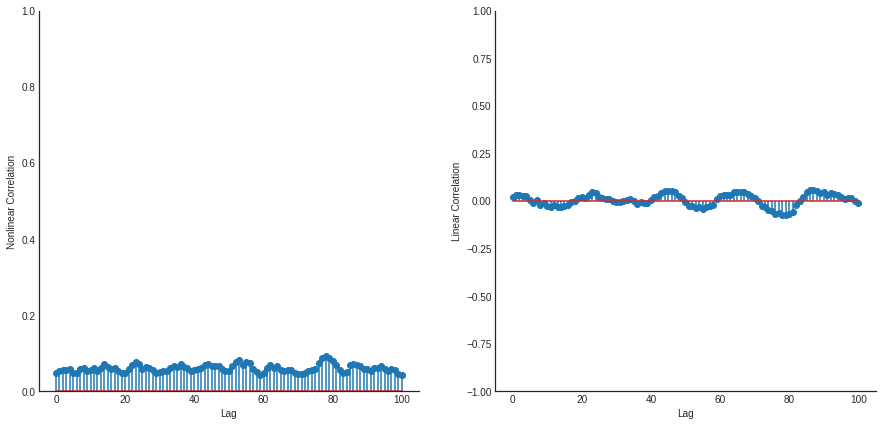

In [218]:
#Plotting cross correlation 
plt.figure(figsize = [15, 7])
 
plt.subplot(121)
plt.stem(correl_lag(ex, x, 100), use_line_collection = True)
plt.ylim(0,1)
plt.xlabel('Lag')
plt.ylabel('Nonlinear Correlation')

plt.subplot(122)
plt.stem(correl_lag_lin(ex, x, 100), use_line_collection = True)
plt.ylim(-1,1)
plt.xlabel('Lag')
plt.ylabel('Linear Correlation')

plt.show()

As we can see, both correlations are low. So, we are going to select and arbitrary value of xlag = 10.

#Building the NARX model

Now that we have defined our lags, we can build our NARX Neural Network. This was done using SysIdentPy library (https://sysidentpy.org/) made by https://github.com/sponsors/wilsonrljr. 

Basically, NARX is Nonlinear Autoregressive Exogenous, which means that the output is a function from the past outputs, inputs and uncertainties.

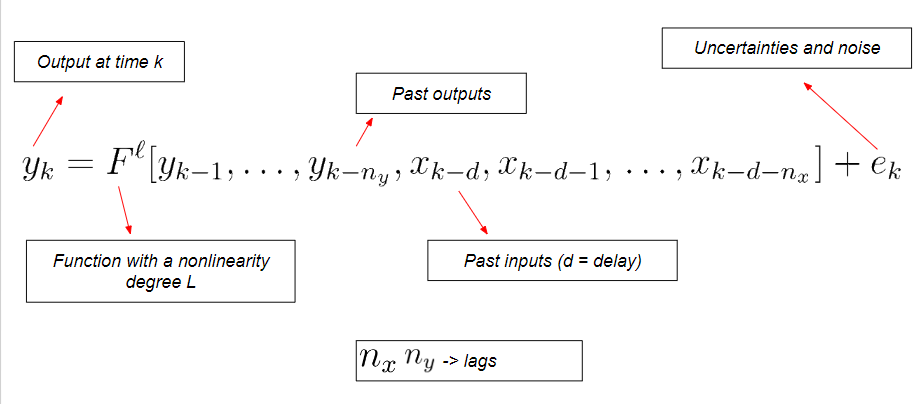

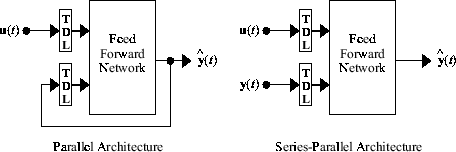

Image from: https://www.mathworks.com/help/deeplearning/ug/design-time-series-narx-feedback-neural-networks.html;jsessionid=3b13e72bd8d62402206e10057095

More information about the NARX model can be found at: https://www.researchgate.net/figure/Nonlinear-autoregressive-with-exogenous-input-NARX-model_fig2_343892524

The model supported by SysIdentPy is build in the Series-Parallel Architecture.

In [208]:
#Creating the NARX model
basis_function = Polynomial(degree=1)

narx_net = NARXNN(
    ylag=5,
    xlag=10,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func='mse_loss',
    optimizer='Adam',
    epochs=300, 
    verbose=True,
    learning_rate=1e-03,
    optim_params={
        'betas': (0.9, 0.999),
        'eps': 1e-08
        } # optional parameters of the optimizer
)

In [209]:
#Creating the Neural Network Architecture. It is important to guarantee that the number of inputs is the same from the features (lags) that we defined.
class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(15, 30)
        self.lin2 = nn.Linear(30, 30)
        self.lin6 = nn.Linear(30, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin6(z)
        return z
        
narx_net.net = NARX() 

In [211]:
narx_net.fit(X=x_train, y=y_train, X_test = x_valid, y_test = y_valid)
tloss = narx_net.train_loss # Training Loss
vloss = narx_net.val_loss # Validation Loss

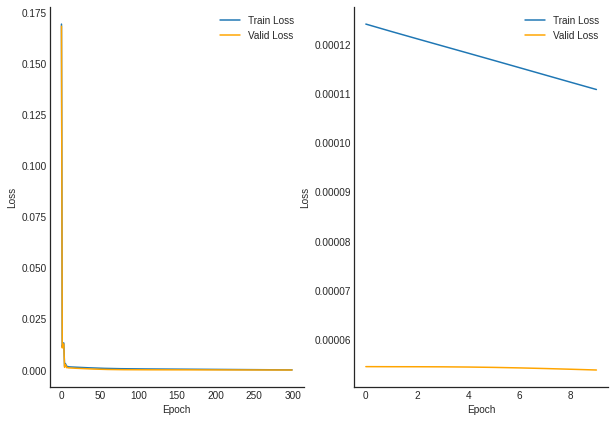

In [217]:
plt.figure(figsize = (10,7))

plt.subplot(121)
plt.plot(tloss, label = 'Train Loss')
plt.plot(vloss, color = 'orange', label = 'Valid Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(tloss[290:], label = 'Train Loss')
plt.plot(vloss[290:], color = 'orange', label = 'Valid Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

Is important to notice that, although the difference is small, the validation loss is lower than the training loss. This could happen due to a lot of factors (https://towardsdatascience.com/what-your-validation-loss-is-lower-than-your-training-loss-this-is-why-5e92e0b1747e#:~:text=Symptoms%3A%20validation%20loss%20is%20consistently%20lower%20than%20the%20training%20loss,a%20layer%20during%20model%20training.). It should be done a more focused analysis to understand what happened. For now we are just gonna ignore this.

In [213]:
yhat = narx_net.predict(X=x_valid, y = y_valid) # Predicting future values

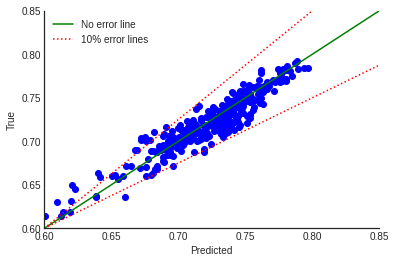

In [223]:
x_points = np.array([0.6, 1])

y_points_down10 = np.array([0.6, 0.9])
y_points_up10 = np.array([0.6, 1.1])

right = np.array([0.6, 1])

plt.plot(yhat, y_valid, 'bo')
plt.plot(x_points, right, color = 'green', label = 'No error line')
plt.plot(x_points, y_points_down10, color = 'red', linestyle = 'dotted', label = '10% error lines')
plt.plot(x_points, y_points_up10 , color = 'red',linestyle = 'dotted')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.xlim([0.6,0.85])
plt.ylim([0.6,0.85])

plt.legend()


plt.show()

The model is not perfect, but we can see that a huge amount of data is inside the 10% error line.

We can see how the next 200 values are predicted by the NARX model and compared with the actual data:

MSE:  0.000153964616762959


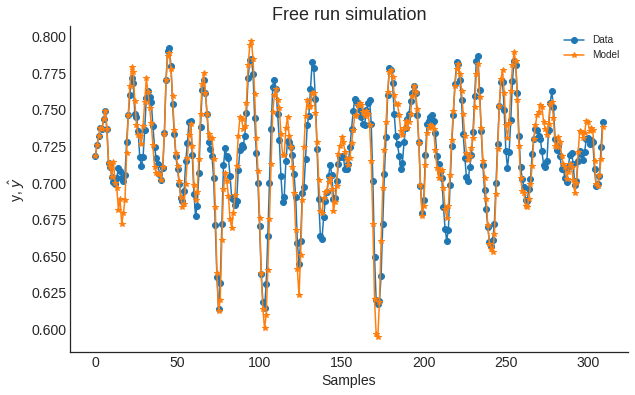

In [222]:
print("MSE: ", mean_squared_error(y_valid, yhat))
plot_results(y=y_valid, yhat=yhat, n=200)

#Building the LSTM model

We can work with time series not just with autoregressive models. Here we build a LSTM model to identify the same mass-springer-damper system. The idea of this model is to maintain the serial dependence from the data using a different neural network structure:

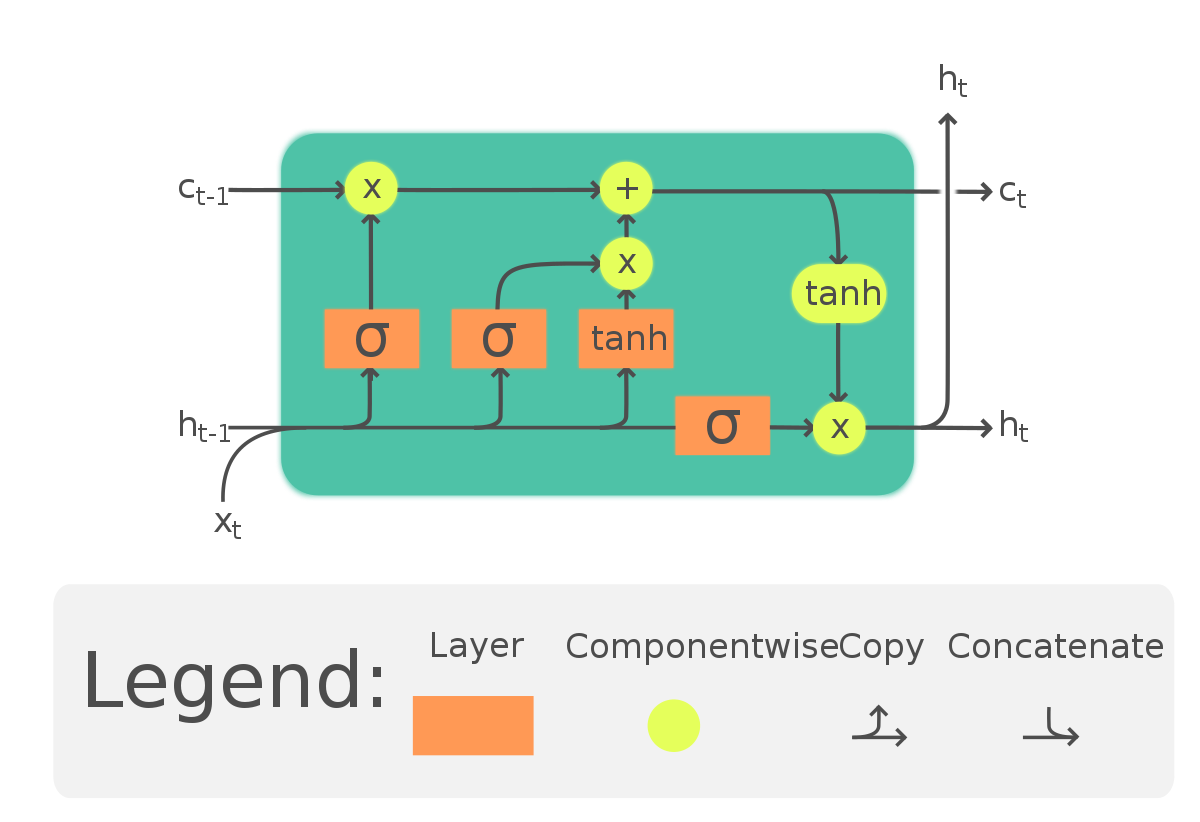

With this, the network has the ability of passing a "memory term".

To train the model we have to reshape the data, as required for LSTM:

In [224]:
#Reshape data

x_train, y_train, x_valid, y_valid = pd.DataFrame(x_train), pd.DataFrame(y_train), pd.DataFrame(x_valid), pd.DataFrame(y_valid)
seq_size = 40

def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

x_train, y_train = to_sequences(x_train, y_train, seq_size)
x_valid, y_valid = to_sequences(x_valid, y_valid, seq_size)

In [229]:
#Creating a basic LSTM neural network structure
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 128)           66560     
                                                                 
 lstm_3 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 87,201
Trainable params: 87,201
Non-trainable params: 0
_________________________________________________________________


The LSTM training will be made with the same amount of epochs that we used before, 300 epochs.

Epoch 1/300
23/23 [==============================] - 4s 81ms/step - loss: 0.3241 - val_loss: 0.0118
Epoch 2/300
23/23 [==============================] - 1s 65ms/step - loss: 0.0344 - val_loss: 0.0045
Epoch 3/300
23/23 [==============================] - 2s 67ms/step - loss: 0.0173 - val_loss: 0.0034
Epoch 4/300
23/23 [==============================] - 2s 65ms/step - loss: 0.0153 - val_loss: 0.0016
Epoch 5/300
23/23 [==============================] - 2s 81ms/step - loss: 0.0142 - val_loss: 0.0026
Epoch 6/300
23/23 [==============================] - 2s 74ms/step - loss: 0.0141 - val_loss: 0.0017
Epoch 7/300
23/23 [==============================] - 2s 77ms/step - loss: 0.0124 - val_loss: 0.0020
Epoch 8/300
23/23 [==============================] - 2s 97ms/step - loss: 0.0121 - val_loss: 0.0018
Epoch 9/300
23/23 [==============================] - 2s 72ms/step - loss: 0.0124 - val_loss: 0.0022
Epoch 10/300
23/23 [==============================] - 2s 78ms/step - loss: 0.0108 - val_loss: 0.0028

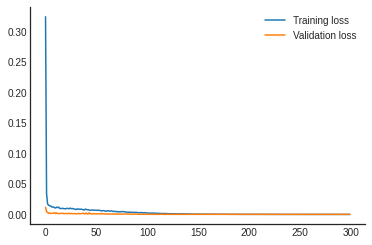

In [231]:
#Training and plotting the losses
history = model.fit(x_train, y_train, epochs=300, batch_size=30, validation_data=(x_valid, y_valid), verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Here, the training loss is higher than the validation loss until the epoch 193.

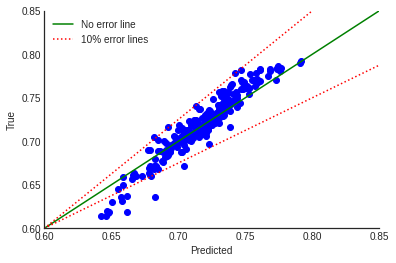

In [232]:
y2 = model.predict(x_valid)

x_points = np.array([0.6, 1])

y_points_down10 = np.array([0.6, 0.9])
y_points_up10 = np.array([0.6, 1.1])

right = np.array([0.6, 1])

plt.plot(y2, y_valid, 'bo')
plt.plot(x_points, right, color = 'green', label = 'No error line')
plt.plot(x_points, y_points_down10, color = 'red', linestyle = 'dotted', label = '10% error lines')
plt.plot(x_points, y_points_up10 , color = 'red',linestyle = 'dotted')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.xlim([0.6,0.85])
plt.ylim([0.6,0.85])

plt.legend()


plt.show()

Again, the model is not perfect, but many points are inside the 10% tolerance, specially the points in the center.

We can see how the next 200 values are predicted by the LSTM model and compared with the actual data:

MSE:  0.00015605248347388845


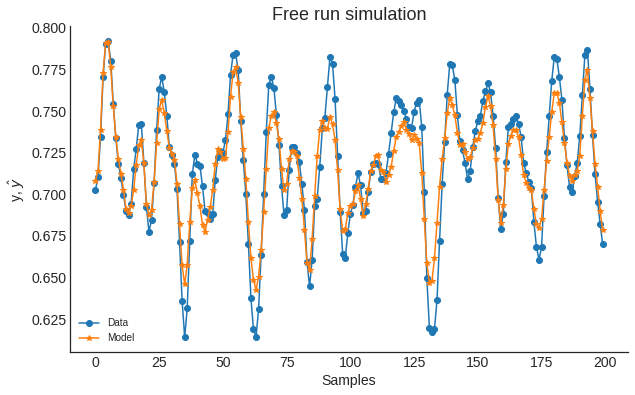

In [234]:
print("MSE: ", mean_squared_error(y_valid, y2))
plot_results(y=y_valid, yhat=y2, n=200)

We can see that the MSE for LSTM is 0.000156 and for the NARX model is 0.000154, which are basically the same value. 

We can refine this analyzis by modifying the networks archictectures/parameters and comparing this model with another force signal, to see if it really identifies the behavior of the mass-springer-damper system.